In [1]:
import eland as ed
import numpy as np
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="AAPL"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_sma = ed.eland_to_pandas(df_eod)[::-1].tail(100).set_index('date_reference')
df_sma['sma_10'] = df_sma['val_close'].rolling(window=10).mean()
df_sma['sma_20'] = df_sma['val_close'].rolling(window=20).mean()

In [4]:
df_sma.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,sma_10,sma_20
date_reference,,,,,,,,
2025-10-17,AAPL,252.29,253.380,247.2700,248.020,49146961,251.505,253.4930
2025-10-20,AAPL,262.24,264.375,255.6300,255.885,90483029,252.060,253.8010
2025-10-21,AAPL,262.77,265.290,261.8300,261.880,46695948,252.689,254.2180
2025-10-22,AAPL,258.45,262.850,255.4300,262.650,45015254,252.728,254.5250
2025-10-23,AAPL,259.58,260.620,258.0101,259.940,32754941,253.282,254.6605


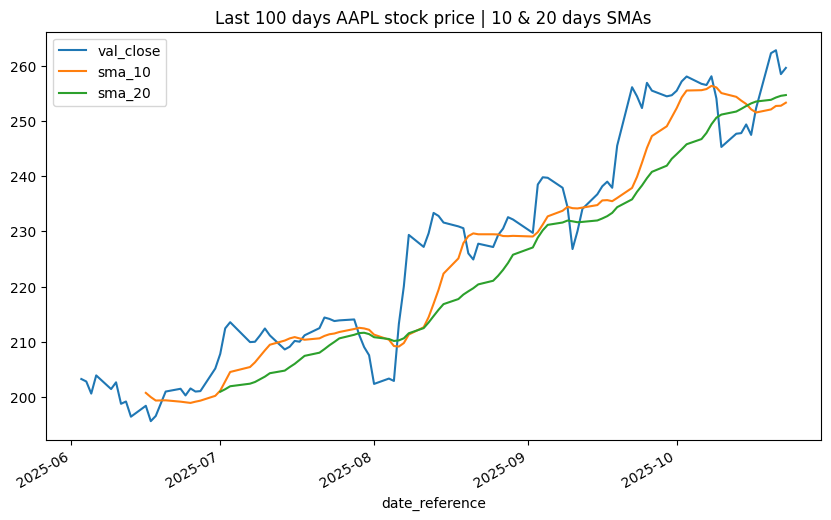

In [5]:
df_sma[["val_close", "sma_10", "sma_20"]].plot(title=f"Last 100 days {ticker} stock price | 10 & 20 days SMAs", figsize=(10, 6));

In [6]:
df_sma['position'] = np.where(df_sma['sma_10'] > df_sma['sma_20'], 1, -1)
df_sma.dropna(inplace=True)

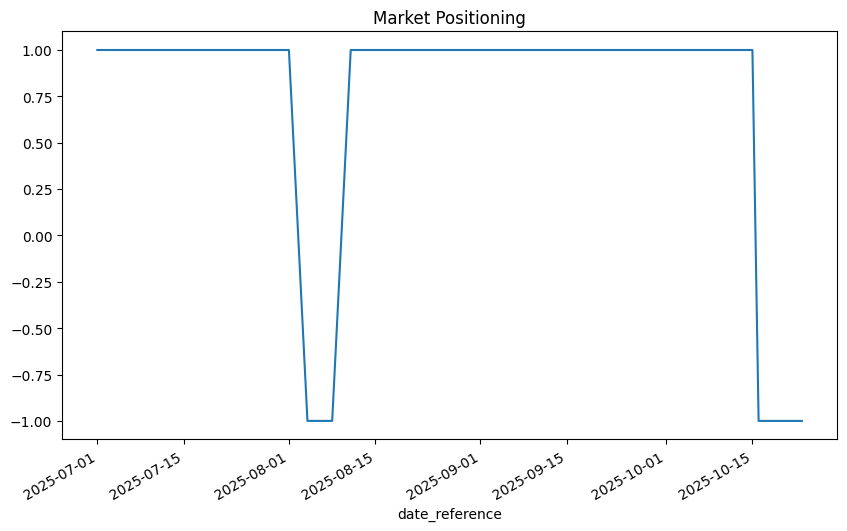

In [7]:
df_sma['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [8]:
df_sma['returns'] = np.log(df_sma['val_close'] / df_sma['val_close'].shift(1))
df_sma['strategy'] = df_sma['position'].shift(1) * df_sma['returns']
df_sma[['returns', 'strategy']].sum().apply(np.exp)

returns     1.249062
strategy    0.909420
dtype: float64

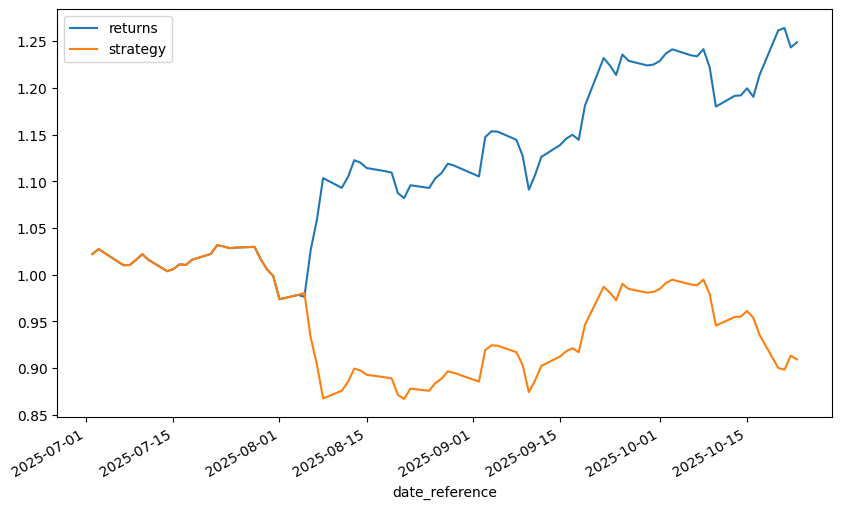

In [9]:
df_sma[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [10]:
df_sma['prev_position'] = df_sma['position'].shift(1)
crossovers = df_sma[df_sma['position'] != df_sma['prev_position']]
print(crossovers[['val_close', 'sma_10', 'sma_20', 'position']])

                val_close   sma_10    sma_20  position
date_reference                                        
2025-07-01         207.82  201.165  200.9630         1
2025-08-04         203.35  210.386  210.5075        -1
2025-08-11         227.18  212.635  212.4770         1
2025-10-16         247.45  252.078  253.1535        -1
